In [51]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold
import numpy as np
import os
import pandas as pd

In [52]:
# training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
# test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
os.chdir("/home/pulkit/AML-Project/Code/")
training_dataset = datasets.CIFAR10(root="data/CIFAR10", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root="data/CIFAR10", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [53]:
image_shape = training_dataset.data[0].shape
if len(image_shape)==2:
  input_channels = 1
  input_dim = tuple(image_shape)
else:
  input_channels = image_shape[2]
  input_dim = tuple(image_shape[:-1])

In [54]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [55]:
class FeedForwardClassifier(torch.nn.Module):
    def __init__(self, output_dim, embed_size) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(embed_size, 250)
        self.fc2 = torch.nn.Linear(250, output_dim)

    def forward(self, embedding):
        x = embedding.squeeze()
        x = torch.nn.ReLU()(self.fc1(x))
        output = self.fc2(x)
        return output

    def predict(self, embedding):
        logits = self.forward(embedding)
        probabilities = torch.nn.Softmax()(logits)
        return torch.argmax(probabilities, dim=1)

In [56]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim, input_channels, input_dim):
        super(Encoder, self).__init__()
        self.input_channels = input_channels
        self.height, self.width = input_dim
        self.layer_height, self.layer_width = self.get_layer_size(3)
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(
                in_channels=input_channels, 
                out_channels=64, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(
                in_channels=64, 
                out_channels=64, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(128*self.layer_height*self.layer_width, 1024),
            torch.nn.LeakyReLU(),
        ])
        self.dense_mu = torch.nn.Linear(1024, z_dim)
        self.dense_logvar = torch.nn.Linear(1024, z_dim)
        
    def get_layer_size(self, layer_num):
        h = self.height
        w = self.width
        for _ in range(layer_num):
            h = int(h/2)
            w = int(w/2)
        return h, w
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        mu = self.dense_mu(x)
        logvar = self.dense_logvar(x)
        return mu, logvar
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim, input_channels, input_dim):
        super(Decoder, self).__init__()
        self.input_channels = input_channels
        self.height, self.width = input_dim
        self.layer_height, self.layer_width = self.get_layer_size(3)
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, self.layer_height*self.layer_width*128),
            torch.nn.ReLU(),
            Reshape((128,self.layer_height,self.layer_width,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(
                in_channels=64, 
                out_channels=64, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, input_channels, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])

    def get_layer_size(self, layer_num):
        h = self.height
        w = self.width
        for _ in range(layer_num):
            h = int(h/2)
            w = int(w/2)
        return h, w
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
class Model(torch.nn.Module):
    def __init__(self, z_dim, strategy, input_channels, input_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim, input_channels, input_dim)
        self.decoder = Decoder(z_dim, input_channels, input_dim)
        self.strategy = strategy
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)

        if self.strategy=="Sampling":
            z = mu + eps * std
        elif self.strategy=="MAP":
            z = mu

        x_reconstructed = self.decoder(z)
        return z, x_reconstructed, mu, logvar

In [57]:
class Trainer:
    def __init__(self, train_loader, val_loader, model_type, sampling_strategy, num_samples, epochs, patience, delta, batch_size, embed_size, input_channels, input_dim):
        # Hyperparameters
        self.embed_size = embed_size
        self.input_channels = input_channels
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.num_samples = num_samples
        self.epochs = epochs
        self.patience = patience
        self.delta = delta

        # Dataloader
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.best_score = None
        self.num_bad_epochs = 0
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        assert model_type=="VAE" or model_type=="MMD"
        self.model_type = model_type
    
        assert sampling_strategy=="Sampling" or sampling_strategy=="MAP"
        self.sampling_strategy = sampling_strategy

        # Model
        self.model = Model(z_dim=self.embed_size, strategy=self.sampling_strategy, input_channels=self.input_channels, input_dim=self.input_dim).to(self.DEVICE)

    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size

    def compute_mmd(self, x, y):
        x_kernel = self.compute_kernel(x, x)
        y_kernel = self.compute_kernel(y, y)
        xy_kernel = self.compute_kernel(x, y)
        mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
        return mmd
    
    def early_stopping(self, fold):
        # Validation Loop
        val_loss = 0
        with torch.no_grad():
            for image, label in tqdm(self.val_loader):
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                true_samples =  torch.randn(self.num_samples, self.embed_size).to(self.DEVICE)
                embedding, out, mu, logvar = self.model.forward(image)

                mse_val_loss = torch.nn.functional.mse_loss(out, image)
                kl_val_loss = torch.mul(input=torch.sum(mu.pow(2) + logvar.exp() - logvar - 1), other=0.5)
                mmd_val_loss = self.compute_mmd(true_samples, embedding)

                if self.model_type=="VAE":
                    val_loss += (mse_val_loss + kl_val_loss)
                elif self.model_type=="MMD":
                    val_loss += (mse_val_loss + mmd_val_loss)
        
        # Early Stopping Condition
        if self.best_score == None:
            self.best_score = val_loss
            model_state_dict = self.model.state_dict()
            torch.save(model_state_dict, f"./weights/VAE/VAE_{fold}_weights.pt")
        elif self.best_score-val_loss>self.delta:
            self.best_score = val_loss
            model_state_dict = self.model.state_dict()
            self.num_bad_epochs = 0
            torch.save(model_state_dict, f"./weights/VAE/VAE_{fold}_weights.pt")
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs==self.patience:
            return True, val_loss
        else:
            return False, val_loss
        
    def training(self, fold):
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()

        for epoch in range(self.epochs):
            # Training Loop
            epoch_loss = 0
            for image, label in tqdm(self.train_loader):
                self.optimizer.zero_grad()
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                # Passing the input image through VAE
                embedding, out, mu, logvar = self.model.forward(image)

                # Mean Square Error Loss (Reconstruction loss in VAE Loss function)
                mse_loss = torch.nn.functional.mse_loss(out, image)

                # Maximum Mean Discrepancy
                true_samples =  torch.randn(self.num_samples, self.embed_size).to(self.DEVICE)
                mmd = self.compute_mmd(true_samples, embedding)

                # KL-Divergence Loss (Regularization loss in VAE Loss function)
                kl_loss = torch.mul(input=torch.sum(mu.pow(2) + logvar.exp() - logvar - 1), other=0.5)

                # Total Loss Function
                if self.model_type=="VAE":
                    loss = mse_loss + kl_loss       # Reconstruction Loss + Regularization Loss
                elif self.model_type=="MMD":
                    loss = mse_loss + mmd           # Reconstruction Loss + Maximum Mean Discrepancy

                loss.backward() # Perform Back-Propogation
                self.optimizer.step() # Performs a single optimization step (parameter update)
                epoch_loss += loss
                del loss, out
                
            early_stopping, val_loss = self.early_stopping(fold)
            print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
            
            if early_stopping:
                print(f'Early Stopping at epoch {epoch}')
                break


In [58]:
class Classifier:
    def __init__(self, model, train_loader, val_loader, test_loader, epochs, num_classes, embed_size, delta, patience):
        self.training_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.epochs = epochs
        self.num_classes = num_classes
        self.embed_size = embed_size
        self.delta = delta
        self.patience = patience
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = model
        self.classifier = FeedForwardClassifier(output_dim=self.num_classes, embed_size=self.embed_size).to(self.DEVICE)

    def early_stopping(self, fold):
        # Validation Loop
        val_loss = 0
        with torch.no_grad():
            for image, label in tqdm(self.val_loader):
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                embedding, _, _, _ = self.model.forward(image)
                prediction = self.classifier.forward(embedding)
                classification_loss = torch.nn.CrossEntropyLoss()(prediction, label)
                val_loss += classification_loss
        
        # Early Stopping
        if self.best_score == None:
            self.best_score = val_loss
            classifier_state_dict = self.classifier.state_dict()
            torch.save(classifier_state_dict, f"./weights/classifier/classifier_{fold}_weights.pt")
        elif self.best_score-val_loss>self.delta:
            self.best_score = val_loss
            classifier_state_dict = self.classifier.state_dict()
            self.num_bad_epochs = 0
            torch.save(classifier_state_dict, f"./weights/classifier/classifier_{fold}_weights.pt")
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs==self.patience:
            return True, val_loss
        else:
            return False, val_loss

    def training(self, fold):
        self.optimizer = torch.optim.Adam(self.classifier.parameters())
        self.best_score = None
        self.num_bad_epochs = 0
        
        for epoch in range(self.epochs):
            # Training Loop
            epoch_loss = 0
            for image, label in tqdm(self.training_loader):
                self.optimizer.zero_grad()
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                with torch.no_grad():
                    # Passing the input image through VAE
                    embedding, _, _, _ = self.model.forward(image)

                # Passing the latent representation through Classifier
                prediction = self.classifier.forward(embedding)
                loss = torch.nn.CrossEntropyLoss()(prediction, label)

                loss.backward() # Perform Back-Propogation
                self.optimizer.step() # Performs a single optimization step (parameter update)
                epoch_loss += loss
                del loss
            
            early_stopping, val_loss = self.early_stopping(fold)
            print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
            
            if early_stopping:
                print(f'Early Stopping at epoch {epoch}')
                break

    def predict(self, fold):
        self.model.load_state_dict(torch.load(f"./weights/VAE/VAE_{fold}_weights.pt"))

        classifier_network = FeedForwardClassifier(output_dim=self.num_classes, embed_size=self.embed_size).to(self.DEVICE)
        classifier_network.load_state_dict(torch.load(f"./weights/classifier/classifier_{fold}_weights.pt"))

        self.model.eval()
        classifier_network.eval()

        correct = 0
        with torch.no_grad():
            for image, label in tqdm(self.test_loader):
                image = image.to(self.DEVICE)
                label = label.to(torch.int32).to(self.DEVICE)

                embedding, _, _, _ = self.model.forward(image)
                prediction = classifier_network.predict(embedding).to(torch.int32)

                correct += int(sum(prediction==label))
                
        accuracy = 100*correct/len(self.test_loader.dataset)
        print(f"Accuracy : {accuracy:.2f}")
        return accuracy
            

In [59]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(training_dataset.classes)
# embed_size = 16
batch_size = 32
num_samples = 200
epochs = 10
patience = 5
delta = 1e-4
# sampling_strategy = "MAP"
# model_type = "MMD"
os.chdir("/home/pulkit/AML-Project/Code/")

In [60]:
training_size = int(len(training_dataset)*0.8)
val_size = len(training_dataset) - training_size
training_data, val_data = torch.utils.data.random_split(training_dataset, [training_size, val_size])

training_loader = DataLoader(training_data, shuffle=False, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size)

In [62]:
embed_sizes = [128]
# sampling_strategies = ["MAP", "Sampling"]
sampling_strategies = ["Sampling"]
# model_types = ["MMD", "VAE"]
model_types = ["MMD"]

for model_type in model_types:
    for sampling_strategy in sampling_strategies:
        accuracies = []
        best_accuracies = []
        for embed_size in embed_sizes:
            k_folds = 5
            kf = KFold(n_splits=k_folds, shuffle=True)
            test_loader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size)
            accuracy = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(training_dataset)):
                print(f"Fold {fold + 1}")
                print("-------")

                # Define the data loaders for the current fold
                train_loader = DataLoader(
                    dataset=torch.utils.data.Subset(training_dataset, train_idx),
                    batch_size=batch_size
                )
                val_loader = DataLoader(
                    dataset=torch.utils.data.Subset(training_dataset, val_idx),
                    batch_size=batch_size,
                )

                # Train VAE Network
                trainer = Trainer(
                    train_loader=train_loader,
                    val_loader=val_loader,
                    sampling_strategy=sampling_strategy,
                    model_type=model_type,
                    num_samples=num_samples,
                    epochs=epochs,
                    patience=patience,
                    delta=delta,
                    batch_size=batch_size,
                    embed_size=embed_size,
                    input_channels=input_channels,
                    input_dim=input_dim
                )
                trainer.training(fold)

                # Load the trained VAE Network
                model = Model(z_dim=embed_size, strategy=sampling_strategy, input_channels=input_channels, input_dim=input_dim).to(DEVICE)
                model.load_state_dict(torch.load(f"./weights/VAE/VAE_{fold}_weights.pt"))

                # Train Classifier Network
                classifier = Classifier(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    test_loader=test_loader,
                    epochs=epochs,
                    num_classes=num_classes,
                    embed_size=embed_size,
                    delta=delta,
                    patience=patience
                )
                classifier.training(fold)
                accuracy.append(classifier.predict(fold))

            accuracies.append(np.mean(accuracy))
            best_accuracies.append(np.max(accuracy))

            print(f"Mean Accuracy : {np.mean(accuracy)}")
            print(f"Best Accuracy : {np.max(accuracy)} at {np.argmax(accuracy)} fold")
            print()
        
        df = pd.DataFrame(list(zip(*[embed_sizes, accuracies, best_accuracies])), columns=["Embedding Dimension", "Mean Accuracy", "Best Accuracy"])
        df.to_csv(f"./results/CIFAR10_{model_type}_{sampling_strategy}.csv")


Fold 1
-------


100%|██████████| 313/313 [00:08<00:00, 37.13it/s]


Epoch: 0; Training Loss: 31.135629653930664; Validation Loss: 5.396955966949463


100%|██████████| 313/313 [00:08<00:00, 36.03it/s]


Epoch: 1; Training Loss: 19.610647201538086; Validation Loss: 4.493559837341309


100%|██████████| 313/313 [00:08<00:00, 38.70it/s]


Epoch: 2; Training Loss: 17.11350440979004; Validation Loss: 4.069973468780518


100%|██████████| 313/313 [00:08<00:00, 37.15it/s]


Epoch: 3; Training Loss: 15.541463851928711; Validation Loss: 3.7298941612243652


100%|██████████| 313/313 [00:08<00:00, 37.02it/s]


Epoch: 4; Training Loss: 14.541712760925293; Validation Loss: 3.6175851821899414


100%|██████████| 313/313 [00:06<00:00, 45.04it/s]


Epoch: 5; Training Loss: 13.941975593566895; Validation Loss: 3.4370079040527344


100%|██████████| 313/313 [00:06<00:00, 44.92it/s]


Epoch: 6; Training Loss: 13.31676959991455; Validation Loss: 3.2862772941589355


100%|██████████| 313/313 [00:06<00:00, 46.25it/s]


Epoch: 7; Training Loss: 12.708333015441895; Validation Loss: 3.1668214797973633


100%|██████████| 313/313 [00:06<00:00, 45.41it/s]


Epoch: 8; Training Loss: 12.273231506347656; Validation Loss: 3.095616340637207


100%|██████████| 313/313 [00:06<00:00, 45.14it/s]


Epoch: 9; Training Loss: 12.01330852508545; Validation Loss: 3.109853506088257


100%|██████████| 313/313 [00:04<00:00, 67.75it/s]


Epoch: 0; Training Loss: 2123.59130859375; Validation Loss: 480.213134765625


100%|██████████| 313/313 [00:05<00:00, 60.21it/s]


Epoch: 1; Training Loss: 1834.9010009765625; Validation Loss: 450.1329040527344


100%|██████████| 313/313 [00:04<00:00, 71.43it/s]


Epoch: 2; Training Loss: 1732.4967041015625; Validation Loss: 437.51904296875


100%|██████████| 313/313 [00:05<00:00, 60.51it/s]


Epoch: 3; Training Loss: 1667.8309326171875; Validation Loss: 430.8373718261719


100%|██████████| 313/313 [00:04<00:00, 71.98it/s]


Epoch: 4; Training Loss: 1620.464599609375; Validation Loss: 427.22589111328125


100%|██████████| 313/313 [00:04<00:00, 71.11it/s]


Epoch: 5; Training Loss: 1583.1678466796875; Validation Loss: 425.1289978027344


100%|██████████| 313/313 [00:04<00:00, 63.44it/s]


Epoch: 6; Training Loss: 1552.90478515625; Validation Loss: 424.36309814453125


100%|██████████| 313/313 [00:04<00:00, 63.65it/s]


Epoch: 7; Training Loss: 1527.793212890625; Validation Loss: 423.8547058105469


100%|██████████| 313/313 [00:05<00:00, 60.86it/s]


Epoch: 8; Training Loss: 1506.5523681640625; Validation Loss: 423.9800109863281


100%|██████████| 313/313 [00:04<00:00, 66.09it/s]


Epoch: 9; Training Loss: 1488.243408203125; Validation Loss: 424.11322021484375


  0%|          | 0/313 [00:00<?, ?it/s]/home/pulkit/anaconda3/envs/flow-VAE/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████| 313/313 [00:05<00:00, 62.39it/s]


Accuracy : 52.63
Fold 2
-------


100%|██████████| 313/313 [00:07<00:00, 44.47it/s]


Epoch: 0; Training Loss: 30.805068969726562; Validation Loss: 5.7346415519714355


100%|██████████| 313/313 [00:07<00:00, 42.52it/s]


Epoch: 1; Training Loss: 19.729496002197266; Validation Loss: 4.7589898109436035


100%|██████████| 313/313 [00:07<00:00, 43.42it/s]


Epoch: 2; Training Loss: 17.401403427124023; Validation Loss: 4.240851402282715


100%|██████████| 313/313 [00:06<00:00, 45.45it/s]


Epoch: 3; Training Loss: 15.961074829101562; Validation Loss: 3.8693952560424805


100%|██████████| 313/313 [00:06<00:00, 45.05it/s]


Epoch: 4; Training Loss: 14.882793426513672; Validation Loss: 3.7773172855377197


100%|██████████| 313/313 [00:06<00:00, 45.77it/s]


Epoch: 5; Training Loss: 14.315472602844238; Validation Loss: 3.618020534515381


100%|██████████| 313/313 [00:07<00:00, 43.69it/s]


Epoch: 6; Training Loss: 13.691715240478516; Validation Loss: 3.5042669773101807


100%|██████████| 313/313 [00:06<00:00, 45.09it/s]


Epoch: 7; Training Loss: 13.049881935119629; Validation Loss: 3.335698127746582


100%|██████████| 313/313 [00:08<00:00, 37.14it/s]


Epoch: 8; Training Loss: 12.537506103515625; Validation Loss: 3.3138930797576904


100%|██████████| 313/313 [00:07<00:00, 43.32it/s]


Epoch: 9; Training Loss: 12.24913215637207; Validation Loss: 3.0924198627471924


100%|██████████| 313/313 [00:04<00:00, 63.73it/s]


Epoch: 0; Training Loss: 2124.68798828125; Validation Loss: 484.7830810546875


100%|██████████| 313/313 [00:05<00:00, 61.22it/s]


Epoch: 1; Training Loss: 1832.377197265625; Validation Loss: 456.7900695800781


100%|██████████| 313/313 [00:05<00:00, 61.94it/s]


Epoch: 2; Training Loss: 1729.068115234375; Validation Loss: 444.3027648925781


100%|██████████| 313/313 [00:04<00:00, 66.39it/s]


Epoch: 3; Training Loss: 1665.232666015625; Validation Loss: 437.2187194824219


100%|██████████| 313/313 [00:04<00:00, 63.34it/s]


Epoch: 4; Training Loss: 1619.5089111328125; Validation Loss: 433.1274719238281


100%|██████████| 313/313 [00:05<00:00, 58.30it/s]


Epoch: 5; Training Loss: 1583.4892578125; Validation Loss: 430.71673583984375


100%|██████████| 313/313 [00:05<00:00, 58.81it/s]


Epoch: 6; Training Loss: 1553.7021484375; Validation Loss: 429.1643371582031


100%|██████████| 313/313 [00:05<00:00, 60.97it/s]


Epoch: 7; Training Loss: 1528.2508544921875; Validation Loss: 428.4143981933594


100%|██████████| 313/313 [00:05<00:00, 58.16it/s]


Epoch: 8; Training Loss: 1506.488525390625; Validation Loss: 428.32061767578125


100%|██████████| 313/313 [00:06<00:00, 51.56it/s]


Epoch: 9; Training Loss: 1487.55712890625; Validation Loss: 428.4584655761719


100%|██████████| 313/313 [00:05<00:00, 53.15it/s]


Accuracy : 53.03
Fold 3
-------


100%|██████████| 313/313 [00:08<00:00, 38.99it/s]


Epoch: 0; Training Loss: 30.81206703186035; Validation Loss: 5.391993045806885


100%|██████████| 313/313 [00:06<00:00, 44.73it/s]


Epoch: 1; Training Loss: 19.66371726989746; Validation Loss: 4.554672718048096


100%|██████████| 313/313 [00:07<00:00, 39.42it/s]


Epoch: 2; Training Loss: 17.08474349975586; Validation Loss: 4.0913801193237305


100%|██████████| 313/313 [00:07<00:00, 42.57it/s]


Epoch: 3; Training Loss: 15.643893241882324; Validation Loss: 3.808117151260376


100%|██████████| 313/313 [00:07<00:00, 43.93it/s]


Epoch: 4; Training Loss: 14.631789207458496; Validation Loss: 3.6667237281799316


100%|██████████| 313/313 [00:07<00:00, 42.96it/s]


Epoch: 5; Training Loss: 14.041705131530762; Validation Loss: 3.4742372035980225


100%|██████████| 313/313 [00:07<00:00, 41.29it/s]


Epoch: 6; Training Loss: 13.362993240356445; Validation Loss: 3.344468593597412


100%|██████████| 313/313 [00:07<00:00, 41.40it/s]


Epoch: 7; Training Loss: 12.840359687805176; Validation Loss: 3.2118377685546875


100%|██████████| 313/313 [00:08<00:00, 38.62it/s]


Epoch: 8; Training Loss: 12.395073890686035; Validation Loss: 3.1193082332611084


100%|██████████| 313/313 [00:07<00:00, 42.37it/s]


Epoch: 9; Training Loss: 11.985708236694336; Validation Loss: 3.0615122318267822


100%|██████████| 313/313 [00:05<00:00, 58.49it/s]


Epoch: 0; Training Loss: 2130.443603515625; Validation Loss: 486.115234375


100%|██████████| 313/313 [00:05<00:00, 57.96it/s]


Epoch: 1; Training Loss: 1843.73193359375; Validation Loss: 457.5479431152344


100%|██████████| 313/313 [00:05<00:00, 61.22it/s]


Epoch: 2; Training Loss: 1737.28125; Validation Loss: 444.35986328125


100%|██████████| 313/313 [00:05<00:00, 57.28it/s]


Epoch: 3; Training Loss: 1669.309814453125; Validation Loss: 437.2217712402344


100%|██████████| 313/313 [00:05<00:00, 55.41it/s]


Epoch: 4; Training Loss: 1620.250244140625; Validation Loss: 433.0871276855469


100%|██████████| 313/313 [00:05<00:00, 58.07it/s]


Epoch: 5; Training Loss: 1582.528564453125; Validation Loss: 430.38348388671875


100%|██████████| 313/313 [00:05<00:00, 59.04it/s]


Epoch: 6; Training Loss: 1552.20654296875; Validation Loss: 429.0446472167969


100%|██████████| 313/313 [00:04<00:00, 63.00it/s]


Epoch: 7; Training Loss: 1526.7060546875; Validation Loss: 428.3968505859375


100%|██████████| 313/313 [00:05<00:00, 62.59it/s]


Epoch: 8; Training Loss: 1504.5050048828125; Validation Loss: 428.30511474609375


100%|██████████| 313/313 [00:05<00:00, 55.62it/s]


Epoch: 9; Training Loss: 1485.322021484375; Validation Loss: 428.33099365234375


100%|██████████| 313/313 [00:05<00:00, 61.10it/s]


Accuracy : 52.53
Fold 4
-------


100%|██████████| 313/313 [00:07<00:00, 41.45it/s]


Epoch: 0; Training Loss: 30.409666061401367; Validation Loss: 5.347603797912598


100%|██████████| 313/313 [00:07<00:00, 40.37it/s]


Epoch: 1; Training Loss: 19.39395523071289; Validation Loss: 4.423980236053467


100%|██████████| 313/313 [00:07<00:00, 40.89it/s]


Epoch: 2; Training Loss: 17.00128173828125; Validation Loss: 4.074300289154053


100%|██████████| 313/313 [00:07<00:00, 41.16it/s]


Epoch: 3; Training Loss: 15.538846969604492; Validation Loss: 3.751739740371704


100%|██████████| 313/313 [00:06<00:00, 46.02it/s]


Epoch: 4; Training Loss: 14.538331031799316; Validation Loss: 3.578542709350586


100%|██████████| 313/313 [00:06<00:00, 45.63it/s]


Epoch: 5; Training Loss: 13.870683670043945; Validation Loss: 3.4151628017425537


100%|██████████| 313/313 [00:06<00:00, 46.40it/s]


Epoch: 6; Training Loss: 13.26021671295166; Validation Loss: 3.3390285968780518


100%|██████████| 313/313 [00:06<00:00, 45.16it/s]


Epoch: 7; Training Loss: 12.676592826843262; Validation Loss: 3.240189552307129


100%|██████████| 313/313 [00:07<00:00, 39.58it/s]


Epoch: 8; Training Loss: 12.270576477050781; Validation Loss: 3.160651445388794


100%|██████████| 313/313 [00:07<00:00, 39.77it/s]


Epoch: 9; Training Loss: 11.982501029968262; Validation Loss: 3.0993714332580566


100%|██████████| 313/313 [00:05<00:00, 55.46it/s]


Epoch: 0; Training Loss: 2124.2236328125; Validation Loss: 487.2240295410156


100%|██████████| 313/313 [00:05<00:00, 56.27it/s]


Epoch: 1; Training Loss: 1836.301025390625; Validation Loss: 459.08251953125


100%|██████████| 313/313 [00:05<00:00, 54.83it/s]


Epoch: 2; Training Loss: 1728.3358154296875; Validation Loss: 446.3075256347656


100%|██████████| 313/313 [00:04<00:00, 64.10it/s]


Epoch: 3; Training Loss: 1659.712646484375; Validation Loss: 439.8438720703125


100%|██████████| 313/313 [00:04<00:00, 63.16it/s]


Epoch: 4; Training Loss: 1611.0916748046875; Validation Loss: 436.3321838378906


100%|██████████| 313/313 [00:05<00:00, 60.23it/s]


Epoch: 5; Training Loss: 1573.508056640625; Validation Loss: 434.6472473144531


100%|██████████| 313/313 [00:05<00:00, 61.18it/s]


Epoch: 6; Training Loss: 1542.5936279296875; Validation Loss: 433.9628601074219


100%|██████████| 313/313 [00:05<00:00, 58.72it/s]


Epoch: 7; Training Loss: 1517.0126953125; Validation Loss: 433.70501708984375


100%|██████████| 313/313 [00:05<00:00, 58.58it/s]


Epoch: 8; Training Loss: 1495.0076904296875; Validation Loss: 433.8469543457031


100%|██████████| 313/313 [00:05<00:00, 61.15it/s]


Epoch: 9; Training Loss: 1475.8251953125; Validation Loss: 434.586669921875


100%|██████████| 313/313 [00:05<00:00, 61.87it/s]


Accuracy : 52.92
Fold 5
-------


100%|██████████| 313/313 [00:07<00:00, 40.18it/s]


Epoch: 0; Training Loss: 30.64063835144043; Validation Loss: 5.218973636627197


100%|██████████| 313/313 [00:07<00:00, 41.91it/s]


Epoch: 1; Training Loss: 19.132612228393555; Validation Loss: 4.384714603424072


100%|██████████| 313/313 [00:07<00:00, 39.54it/s]


Epoch: 2; Training Loss: 16.96942710876465; Validation Loss: 4.055822849273682


100%|██████████| 313/313 [00:07<00:00, 40.76it/s]


Epoch: 3; Training Loss: 15.571538925170898; Validation Loss: 3.710840940475464


100%|██████████| 313/313 [00:07<00:00, 40.09it/s]


Epoch: 4; Training Loss: 14.513476371765137; Validation Loss: 3.5576398372650146


100%|██████████| 313/313 [00:07<00:00, 40.09it/s]


Epoch: 5; Training Loss: 13.832806587219238; Validation Loss: 3.4004318714141846


100%|██████████| 313/313 [00:07<00:00, 44.43it/s]


Epoch: 6; Training Loss: 13.210783004760742; Validation Loss: 3.3087611198425293


100%|██████████| 313/313 [00:07<00:00, 39.86it/s]


Epoch: 7; Training Loss: 12.741700172424316; Validation Loss: 3.191237688064575


100%|██████████| 313/313 [00:07<00:00, 43.29it/s]


Epoch: 8; Training Loss: 12.28451156616211; Validation Loss: 3.114274740219116


100%|██████████| 313/313 [00:07<00:00, 40.79it/s]


Epoch: 9; Training Loss: 11.884577751159668; Validation Loss: 3.020245313644409


100%|██████████| 313/313 [00:05<00:00, 55.49it/s]


Epoch: 0; Training Loss: 2130.181884765625; Validation Loss: 480.3256530761719


100%|██████████| 313/313 [00:05<00:00, 57.71it/s]


Epoch: 1; Training Loss: 1837.8695068359375; Validation Loss: 451.9325256347656


100%|██████████| 313/313 [00:05<00:00, 57.99it/s]


Epoch: 2; Training Loss: 1730.6031494140625; Validation Loss: 439.5067138671875


100%|██████████| 313/313 [00:05<00:00, 60.72it/s]


Epoch: 3; Training Loss: 1663.0380859375; Validation Loss: 433.0455627441406


100%|██████████| 313/313 [00:05<00:00, 56.51it/s]


Epoch: 4; Training Loss: 1614.4852294921875; Validation Loss: 429.3663635253906


100%|██████████| 313/313 [00:05<00:00, 57.45it/s]


Epoch: 5; Training Loss: 1577.3048095703125; Validation Loss: 427.2452087402344


100%|██████████| 313/313 [00:04<00:00, 63.51it/s]


Epoch: 6; Training Loss: 1547.1434326171875; Validation Loss: 426.3221130371094


100%|██████████| 313/313 [00:04<00:00, 64.10it/s]


Epoch: 7; Training Loss: 1522.1365966796875; Validation Loss: 425.8262634277344


100%|██████████| 313/313 [00:05<00:00, 58.86it/s]


Epoch: 8; Training Loss: 1500.6058349609375; Validation Loss: 426.16912841796875


100%|██████████| 313/313 [00:05<00:00, 59.12it/s]


Epoch: 9; Training Loss: 1481.9964599609375; Validation Loss: 426.7102355957031


100%|██████████| 313/313 [00:05<00:00, 56.49it/s]


Accuracy : 52.53
Mean Accuracy : 52.727999999999994
Best Accuracy : 53.03 at 1 fold



## **Plot Latent Space**

313it [00:05, 55.90it/s]


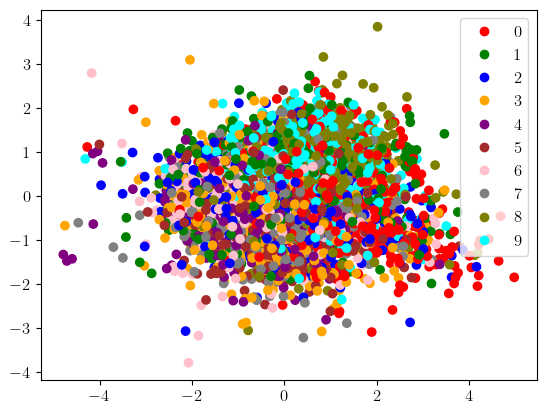

In [66]:
# Load Models
# make latex plot font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 12
})

pca = PCA(n_components=2)
best_fold = np.argmax(accuracy)
model = Model(z_dim=embed_size, strategy=sampling_strategy, input_channels=input_channels, input_dim=input_dim).to(DEVICE)
model.load_state_dict(torch.load(f"./weights/VAE/VAE_{1}_weights.pt"))

# Label, Embedding Matrices
size = len(test_dataset)
embedding = torch.zeros((size, embed_size))
y = torch.zeros(size)

with torch.no_grad():
  for i, (image, label) in tqdm(enumerate(test_loader)):
    # image = image.squeeze()
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    z, _, _, _ = model.forward(image)
    embedding[i*batch_size:min((i+1)*batch_size, size)] = z
    y[i*batch_size:min((i+1)*batch_size, size)] = label

if embed_size != 2:
  embedding = pca.fit_transform(embedding)

colors = ['red','green','blue','orange','purple','brown','pink','gray','olive','cyan']
colours = ListedColormap(colors)
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=y, cmap=colours)
plt.legend(*scatter.legend_elements())
plt.savefig("./latent.png", format="png")

In [65]:
model.load_state_dict(torch.load(f"./weights/VAE/VAE_{best_fold}_weights.pt"))
classifier_network = FeedForwardClassifier(output_dim=num_classes, embed_size=embed_size).to(DEVICE)
classifier_network.load_state_dict(torch.load(f"./weights/classifier/classifier_{best_fold}_weights.pt"))

model.eval()
classifier_network.eval()

correct = 0
with torch.no_grad():
  for image, label in tqdm(test_loader):
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    embedding, _, _, _ = model.forward(image)
    prediction = classifier_network.predict(embedding).to(torch.int32)

    correct += int(sum(prediction==label))
print()
print(f"Accuracy : {100*correct/len(test_loader.dataset):.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]/home/pulkit/anaconda3/envs/flow-VAE/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████| 313/313 [00:05<00:00, 52.76it/s]


Accuracy : 53.04
